From **https://github.com/bayesgroup/deepbayes-2019/tree/master/seminars**

In [1]:
# some prelimenaries
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt

torch.manual_seed(0)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('Using torch version {}'.format(torch.__version__))
print('Using {} device'.format(device))
  
# Training dataset
train_loader = torch.utils.data.DataLoader(
    MNIST(root='.', train=True, download=True,
          transform=transforms.ToTensor()),
    batch_size=100, shuffle=True, pin_memory=True)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    MNIST(root='.', train=False, transform=transforms.ToTensor()),
    batch_size=100, shuffle=True, pin_memory=True)

0it [00:00, ?it/s]

Using torch version 1.2.0
Using cuda:0 device


9920512it [00:02, 4278482.68it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 56902.29it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:01, 1303819.34it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 19031.95it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


# Practical Session. Variational Autoencoders

During this practical session, you will implement a vanilla VAE on MNIST and then a VAE extension with multiple latent variables. Both implementations will be based on classes for parametric probabilistic distributions from the torch [*torch.distributions*](https://pytorch.org/docs/stable/distributions.html) module to emphasize the probabilistic nature of the models.

To complete the task, you will have read the notebook and construct two loss functions using the classes and then train the models.

# AEs  vs. VAEs

As illustrated below, autoencoders can provide good reconstruction quality. 

![Autoencoder reconstructions](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/ae_reconstructions.png?raw=true)

Still, the model has no control over the learned latent representations. For example, an interpolation of latent representations of two digits is typically not a latent representation for a digit:

![Autoencoder interpolations](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/ae_interpolations.png?raw=true)

On the other hand, a standard VAE model forces latent representation to fit a multivariate Gaussian distribution. As a result, an interpolation of two latent representations is likely to be a latent representation of a digit.

# Distributions for VAE

For the assignment, we will need two types of distributions to define the probabilistic model. For the representation $z$ we need a multivariate [normal distribution](https://pytorch.org/docs/stable/distributions.html#normal) with diagonal covariance matrix (to put another way, a vector of independent normal random variables). For observations $x$, we will need a vector of independent [Bernoulli](https://pytorch.org/docs/stable/distributions.html#bernoulli) random variables. By default, both classes model a tensor of independent random **variables**. To represent a matrix of independent random variables as a batch of random **vectors** you may also use the [Independent](https://pytorch.org/docs/stable/distributions.html#independent) class.

### Bernoulli random vector

While the class can be initialized both with probabilities and logits, the best practice is to initialize the class with logits. Otherwise, computing logarithm of probability can be highly unstable. 

In the tasks, you will use this class to model $p(x | z)$ parametrized by the output of the decoder. To define the loss function you will need to compute $\log p(x | z)$ for input images using *log_prob()* method.

### Normal Distribution

In this task, you will use the class to define the approximate posterior distribution $q(x | z)$ and the latent variable distribution $p(z)$.

Again, you will use *log_prob()* method to compute the loss function. Besides that, you will need to generate a sample from $q(x | z)$ to pass it to the decoder. To implement the reparametrization trick the class defines a specific method *rsample()*, that computes $z = \mu(x) + \varepsilon \odot \sigma(x)$ for standard Gaussian noise $\varepsilon$. Notice that the implementation of *rsample()* method differs from the implementation of *sample()* method.

In [2]:
from torch.distributions import Normal, Bernoulli, Independent

# Vanilla VAE

A variational autoencoder consists of two components. The first component is a probabilistic model for observations: 
\begin{align}
& p(x, z \mid \theta) =  p(z) p(x \mid z, \theta) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid z, \theta) = \prod_{i = 1}^D p_i(z, \theta)^{x_i} (1 - p_i(z, \theta))^{1 - x_i}.
\end{align}
The second component is a variational approximation, used to compute the lower bound on marginal likelihood (VAE uses the negative lower bound as a loss function)
\begin{equation}
q(z \mid x, \phi) = \mathcal N(z \mid \mu(x, \phi), \operatorname{diag}(\sigma^2(x, \phi))).
\end{equation}
The lower bound for probability of observing $x$ from a minibatch is
$$ \mathcal L(x, \theta, \phi) = \mathbb E_{q(z \mid x, \phi)} \left[ \log p(x \mid z, \phi) + \log p(z) - \log q(z \mid x, \theta) \right] $$
However, it is impossible to compute the expectation. The standard practice is to approximate it with the following one-sample Monte-Carlo estimate:
\begin{align*}
\log p(x \mid z_0, \phi) + \log p(z_0) - \log q(z_0 \mid x, \theta) \\
z_0 = \mu(x, \phi) + \sigma^2(x, \phi)^T \varepsilon_0 \\
\varepsilon_0 \sim \mathcal N(0, I)
\end{align*}
*Note that this choice of the Monte-Carlo estimate for expectation is crucial and is typically reffered to as* **reparametrization trick.** For more details see [Auto-encoding Variational Bayes](https://arxiv.org/abs/1312.6114) paper.

Finally, to train the model we average the lower bound values over the minibatch and then maximize the average with gradient ascent:
$$ \frac{1}{N} \sum_{n=1}^N \log p(x_n \mid z_n, \phi) + \log p(z_n) - \log q(z_n \mid x_n, \theta) \rightarrow \max_{\theta, \phi} $$
## Encoder and decoder

$q(z\mid x, \theta)$ is usually called encoder and $p(x \mid z, \phi)$ is usually called decoder. To parametrize these distributions we introduce two neural networks:

- *enc* takes $x$ as input and return $2 \times d$-dimensional vector to parametrize mean and standard deviation of $q(z \mid x, \theta)$
- *dec* takes a latent representation $z$ and returns the logits of distribution $p(x \mid z, \phi)$.

The computational graph has a simple structure of autoencoder. The only difference is that now it uses a stochastic variable $\varepsilon$:

![vae](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/vae.png?raw=true)

Below we initialize a couple of simple fully-connected networks to model the two distributions. 

In [3]:
d, nh, D = 32, 100, 28 * 28

enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, 2 * d)) # note that the final layer outputs real values

dec = nn.Sequential(
    nn.Linear(d, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, D)).to(device) # <-----------------------------------------------

enc = enc.to(device)
dec = dec.to(device)

## Task 1: VAE Loss function

Implement the loss function for the variational autoencoder

In [4]:
def loss_vae(x, encoder, decoder):
    """
    TODO
    returns
    1. the avergave value of negative ELBO across the minibatch x
    2. and the output of the decoder
    """
    batch_size = x.size(0)
    encoder_output = encoder(x)
    pz = Independent(Normal(loc=torch.zeros(batch_size, d).to(device),
                            scale=torch.ones(batch_size, d).to(device)),
                     reinterpreted_batch_ndims=1)
    qz_x = Independent(Normal(loc=encoder_output[:, :d],
                              scale=torch.exp(encoder_output[:, d:])),
                       reinterpreted_batch_ndims=1)
    
    z = qz_x.rsample()
    decoder_output = decoder(z)
    px_z = Independent(Bernoulli(logits=decoder_output), 
                       reinterpreted_batch_ndims=1)
    loss = -(px_z.log_prob(x) + pz.log_prob(z) - qz_x.log_prob(z)).mean()
    return loss, decoder_output

## Training
The cell below implements a simple training function that can be used for both models.

In [5]:
from itertools import chain

def train_model(loss, model, batch_size=100, num_epochs=3, learning_rate=1e-3):
    gd = torch.optim.Adam(
        chain(*[x.parameters() for x in model
                if (isinstance(x, nn.Module) or isinstance(x, nn.Parameter))]),
        lr=learning_rate)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            gd.zero_grad()
            batch = batch.view(-1, D).to(device)
            loss_value, _ = loss(batch, *model)
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.view(-1, D).to(device)
            batch_loss, _ = loss(batch, *model)
            test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

In [6]:
# my implementation has test loss = -110.59
train_model(loss_vae, model=[enc, dec], num_epochs=16)

Train loss: 169.43792724609375 Batch 600 of 600           
Test loss after an epoch: 175.13485717773438
Train loss: 147.82078552246094 Batch 600 of 600           
Test loss after an epoch: 142.6123809814453
Train loss: 135.18846130371094 Batch 600 of 600           
Test loss after an epoch: 130.46217346191406
Train loss: 126.74058532714844 Batch 600 of 600           
Test loss after an epoch: 123.96446990966797
Train loss: 121.46304321289062 Batch 600 of 600           
Test loss after an epoch: 120.21505737304688
Train loss: 113.53367614746094 Batch 600 of 600           
Test loss after an epoch: 117.87570190429688
Train loss: 121.60348510742188 Batch 600 of 600           
Test loss after an epoch: 116.09770202636719
Train loss: 113.0107192993164 Batch 600 of 600            
Test loss after an epoch: 114.86944580078125
Train loss: 112.56523132324219 Batch 600 of 600           
Test loss after an epoch: 114.13661193847656
Train loss: 120.68441772460938 Batch 600 of 600           
Test l

## Visualisations

- How do reconstruction compare to reconstructions of autoencoder?
- Interpolations?
- Is the latent space regularly covered? 
- Is there any dependence between T-SNE encoding and the digit label?

In [7]:
def sample_vae(dec, n_samples=50):
    with torch.no_grad():
        samples = torch.sigmoid(dec(torch.randn(n_samples, d).to(device)))
        samples = samples.view(n_samples, 28, 28).cpu().numpy()
    return samples
    
def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

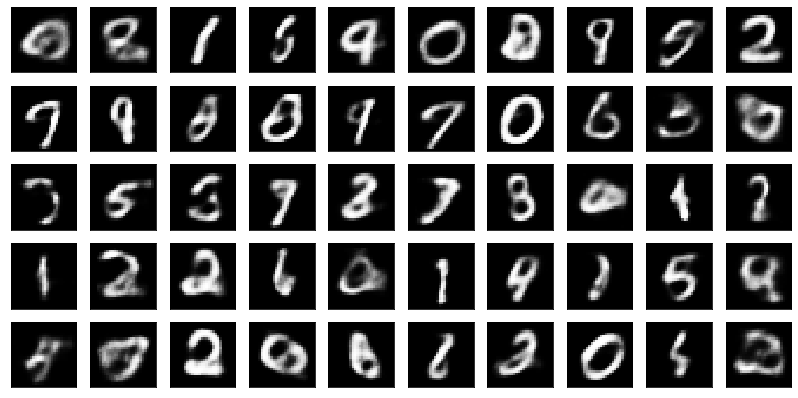

In [8]:
plot_samples(sample_vae(dec=dec))

In [9]:
def plot_reconstructions(loss, model):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:25].float() / 255.)
        batch = batch.view(-1, D).to(device)
        _, rec = loss(batch, *model)
        rec = torch.sigmoid(rec)
        rec = rec.view(-1, 28, 28).cpu().numpy()
        batch = batch.view(-1, 28, 28).cpu().numpy()
    
        fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i in range(25):
            axes[i % 5, 2 * (i // 5)].imshow(batch[i], cmap='gray')
            axes[i % 5, 2 * (i // 5) + 1].imshow(rec[i], cmap='gray')

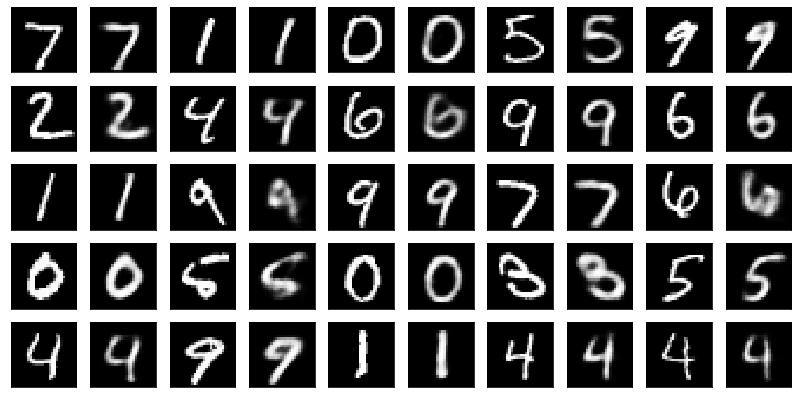

In [10]:
plot_reconstructions(loss_vae, [enc, dec])

In [11]:
def plot_interpolations(encoder, decoder):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:10].float() / 255.)
        batch = batch.view(-1, D).to(device)
        batch = encoder(batch)
        z_0 = batch[:5, :d].view(5, 1, d)
        z_1 = batch[5:, :d].view(5, 1, d)
        
        alpha = torch.linspace(0., 1., 10).to(device)
        alpha = alpha.view(1, 10, 1)
        
        interpolations_z = (z_0 * alpha + z_1 * (1 - alpha))
        interpolations_z = interpolations_z.view(50, d)
        interpolations_x = torch.sigmoid(decoder(interpolations_z))
        interpolations_x = interpolations_x.view(5, 10, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(50):
        axes[i // 10, i % 10].imshow(interpolations_x[i // 10, i % 10], cmap='gray')

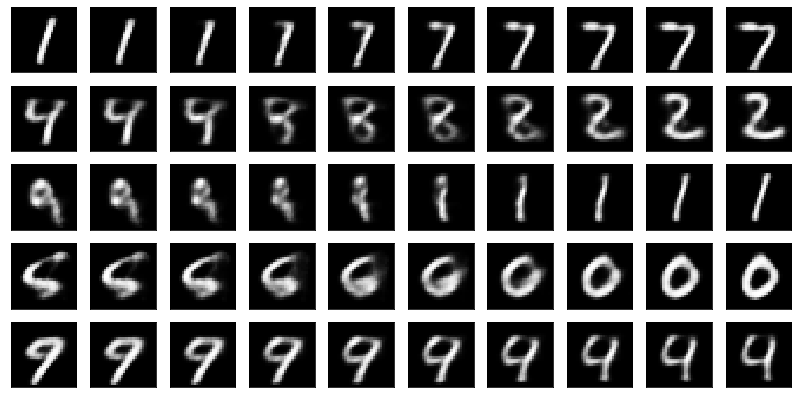

In [12]:
plot_interpolations(enc, dec)

In [13]:
def plot_tsne(objects, labels):
    from sklearn.manifold import TSNE
    embeddings = TSNE(n_components=2).fit_transform(objects)
    plt.figure(figsize=(8, 8))
    for k in range(10):
        embeddings_for_k = embeddings[labels == k]
        plt.scatter(embeddings_for_k[:, 0], embeddings_for_k[:, 1],
                    label='{}'.format(k))
    plt.legend()

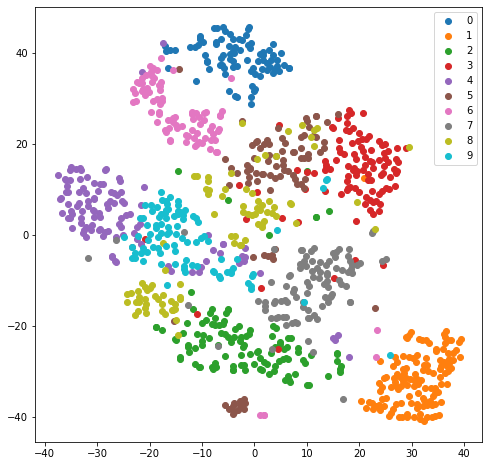

In [14]:
with torch.no_grad():
    batch = (test_loader.dataset.data[:1000].float() / 255.)
    batch = batch.view(-1, D).to(device)

    latent_variables = enc(batch)[:, :d]
    latent_variables = latent_variables.cpu().numpy()
    labels = test_loader.dataset.targets[:1000].numpy()

plot_tsne(latent_variables, labels)